### note: implement dice as a callback

### imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
from fastai.vision.interpret import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [4]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [5]:
torch.cuda.set_device(4)

In [6]:
chexpert_stats = [tensor([0.5381, 0.5381, 0.5381]), tensor([0.2820, 0.2820, 0.2820])]

### databunch

In [7]:
bs,sz = 16,224
tfms = get_transforms()

In [8]:
# #image ids with a mask - with pneumothorax
# image_ids = [o.stem for o in (data_path/f'train/masks_{sz}').ls()]
# seg_df = pd.DataFrame()
# seg_df['ImageId'] = image_ids
# seg_df.to_csv(data_path/'seg_df.csv', index=False)

In [9]:
get_y_fn = lambda x: data_path/f'train/masks_{sz}/{Path(x).stem}.png'
codes = ['void', 'pthorax']

In [10]:
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [11]:
tfms = get_transforms()

data = (SegmentationItemList.from_csv(data_path, 'seg_df.csv', folder=f'train/images_{sz}', suffix='.jpg')
        .split_by_rand_pct(0.1, seed=42)
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms=tfms, size=sz, tfm_y=True, resize_method=ResizeMethod.NO, padding_mode='reflection')
        .databunch(bs=bs)
        .normalize(chexpert_stats))

In [12]:
data

ImageDataBunch;

Train: LabelList (2142 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../../data/siim_acr_pneu;

Valid: LabelList (237 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../../data/siim_acr_pneu;

Test: None

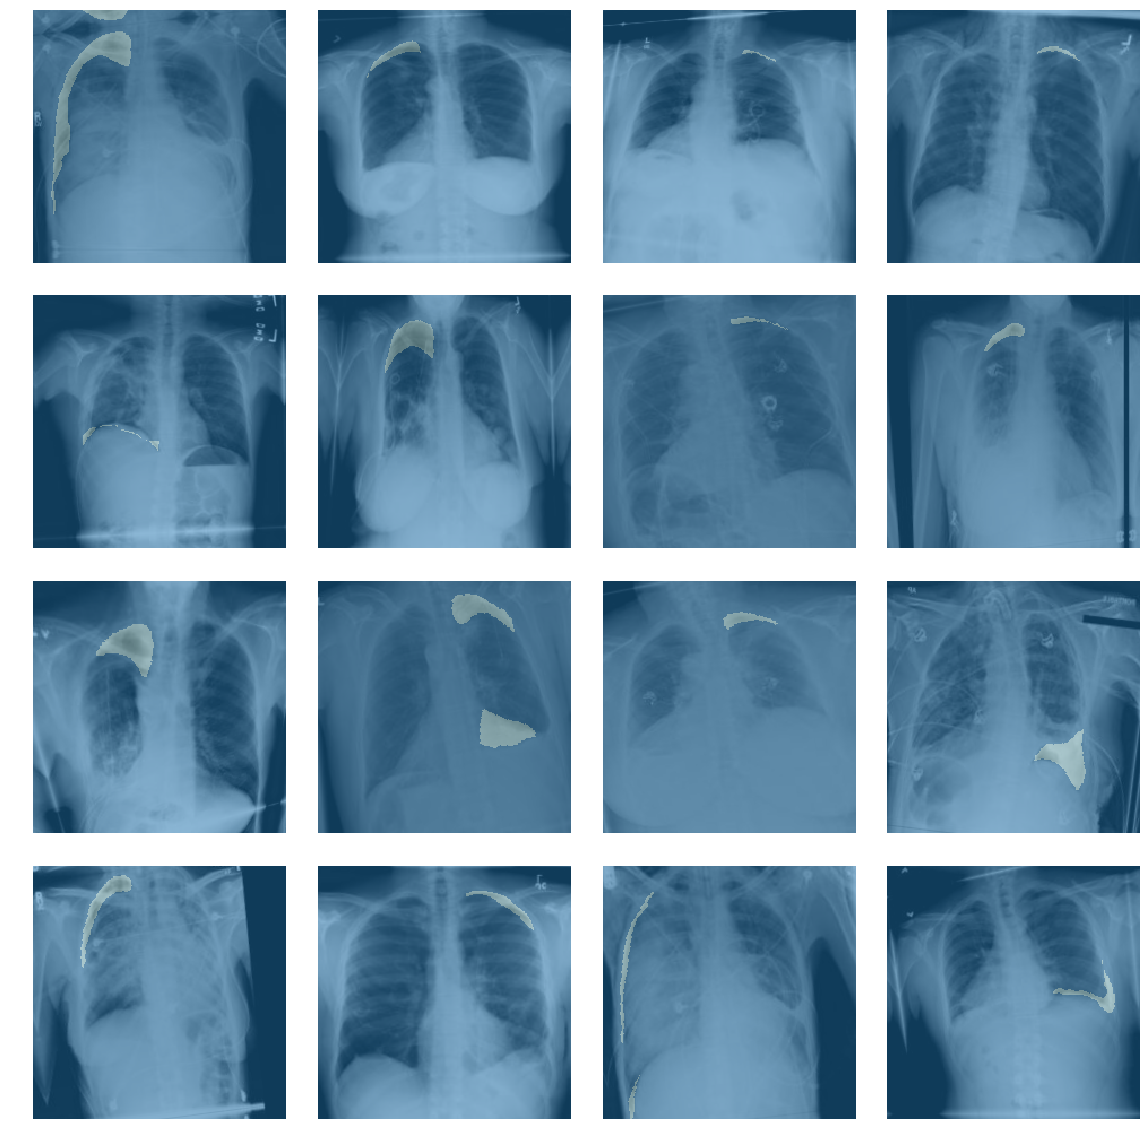

In [93]:
data.show_batch()

In [13]:
len(data.train_ds), len(data.valid_ds)

(2142, 237)

### model

In [14]:
# alternative losses 
def dice_loss(logits, target, smooth=1.):
    logits = torch.sigmoid(logits)
    iflat = logits.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, logits, target):
        logits = logits.squeeze(1)
        if not (target.size() == logits.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), logits.size()))

        max_val = (-logits).clamp(min=0)
        loss = logits - logits * target + max_val + \
            ((-max_val).exp() + (-logits - max_val).exp()).log()

        invprobs = F.logsigmoid(-logits * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(1 - dice_loss(input, target))
        return loss.mean()    

In [15]:
def xresnet50(pretrained=True):
    return models.xresnet50(pretrained=pretrained)

def xresnet34(pretrained=True):
    return models.xresnet34(pretrained=pretrained)

In [16]:
# learn = unet_learner(data, models.resnet34, pretrained=False, metrics=dice)
learn = unet_learner(data, xresnet34, pretrained=False, metrics=dice)

In [18]:
# finetune from chexpert model
# chexpert_state_dict = torch.load("../../data/chexpert/models/u-ignore-resnet34-224.pth")
# chexpert_state_dict = torch.load("../../data/chexpert/models/u-ignore-resnext34-224.pth")
clas_state_dict = torch.load("../../data/siim_acr_pneu/models/clas-chexpert-ft-resnext34-224.pth")

In [20]:
# load state dict from chexpert model until last fully connected layer
for n, p in list(learn.model[0].named_parameters())[:-2]:
#     p.data = chexpert_state_dict['model']['0.'+n].to(torch.device(4))
#     p.data = chexpert_state_dict['model'][n].to(torch.device(4))
    p.data = clas_state_dict['model'][n].to(torch.device(4))

In [21]:
learn.to_fp16();

In [22]:
learn.freeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


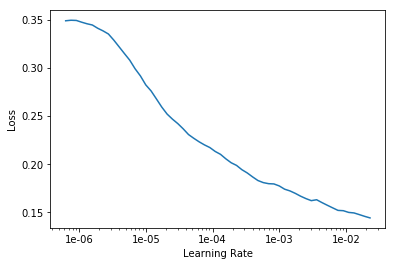

In [24]:
learn.recorder.plot()

In [25]:
lr = 2e-3
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,dice,time
0,0.058357,0.054300,0.000731,00:38
1,0.054953,0.050246,0.000000,00:36
2,0.051289,0.044010,0.003720,00:36
3,0.044666,0.042079,0.301938,00:37
4,0.041735,0.039129,0.274495,00:37
5,0.039721,0.037846,0.434721,00:37
6,0.036750,0.036018,0.417370,00:37
7,0.035118,0.038584,0.276829,00:37
8,0.033422,0.035115,0.395702,00:37
9,0.031274,0.034928,0.392256,00:37


In [26]:
learn.unfreeze()

In [28]:
lr /= 2
learn.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,dice,time
0,0.033261,0.034615,0.417914,00:39
1,0.032133,0.036324,0.322604,00:39
2,0.032876,0.037057,0.385426,00:39
3,0.033057,0.035134,0.407342,00:39
4,0.031346,0.035585,0.398986,00:39
5,0.030542,0.034894,0.458867,00:39
6,0.029453,0.035366,0.396790,00:39
7,0.028637,0.035177,0.394134,00:39
8,0.027272,0.034572,0.442003,00:39
9,0.027568,0.035228,0.418695,00:39


In [107]:
learn.to_fp32();

In [108]:
# learn.save(f"seg-resnet34-{sz}")
# learn.save(f"seg-chexpert-ft-resnet34-{sz}")
learn.save(f"seg-chexpert-ft-resnext34-{sz}")

### add test

In [109]:
test = ImageList.from_folder(data_path/f'test/images_{sz}', extensions='.jpg')

In [110]:
learn.data.add_test(test, tfm_y=False)

In [111]:
# learn.load(f"seg-resnet34-{sz}");
# learn.load(f"seg-chexpert-ft-resnet34-{sz}");
learn.load(f"seg-chexpert-ft-resnext34-{sz}");

### save all learn obj

In [112]:
os.makedirs(data_path/"learn", exist_ok=True)

In [113]:
with ModelOnCPU(learn.model) as model:
#     try_save({"data":learn.data, "model":model}, data_path, f"learn/seg-chexpert-ft-resnet34-{sz}")
    try_save({"data":learn.data, "model":model}, data_path, f"learn/seg-chexpert-ft-resnext34-{sz}")

### interpret

In [1]:
interp = SegmentationInterpretation.from_learner(learn=learn)

NameError: name 'SegmentationInterpretation' is not defined

In [ ]:
top_losses, top_idxs = interp.top_losses((224,224))

In [ ]:
top_losses.shape, top_idxs.shape

In [ ]:
interp.show_xyz(np.random.choice(top_idxs))